In [1]:
## To Fix the seeds (random number generators) and obtian reproducible results

import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers 
import random
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

In [2]:
from keras import models
from keras import layers

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
data=pd.read_csv('C:\\Users\\c2074370\\1-projects\\Phys_Descrip.txt')


In [4]:

PhyD_Names = ['N', 'infa_C_Au', 'infa_S_Mg', 'infa_S_O', 'cc', 'cs_Mg', 'cs_O', 
             'ave_GCN', 'csDist_Mg', 'csDist_O', 'Zdist', 'Ecoh', 'Eadh', 'Eb', 'Etot']
PhyD = np.loadtxt('C:\\Users\\c2074370\\1-projects\\Raw_Phys_Descrip.txt', delimiter=',', dtype=float)
    
Config = np.concatenate((np.repeat('1Au',104), np.repeat('2Au',104), np.repeat('3Au',105), 
                         np.repeat('4Au_a',102), np.repeat('4Au_b',45), np.repeat('4Au_c',103), 
                         np.repeat('4Au_d',104), np.repeat('4Au_e',105), np.repeat('4Au_f',96), 
                         np.repeat('5Au_a',103), np.repeat('5Au_b',103), np.repeat('5Au_c',103),
                         np.repeat('5Au_d',104), np.repeat('5AU_e',102),
                         np.repeat('6Au_a',105), np.repeat('6Au_b',105), 
                         np.repeat('9Au_a',99), np.repeat('9Au_b',79), 
                         np.repeat('12Au_a',12), 
                         np.repeat('24Au_b',56)))

Cl_XYZ = pd.DataFrame.to_numpy( pd.read_csv('C:\\Users\\c2074370\\1-projects\\Cluster_XYZ.csv', header=None, names=range(3*24)) )

Nobs = PhyD.shape[0]

In [5]:
# Recall: in python, numbering start from 0 (and from 1 in R) 
entry_nb = 388 

N_atom = int(PhyD[entry_nb,0])
 
Mat_XYZ = (Cl_XYZ[entry_nb, :(3*N_atom)]).reshape((N_atom, 3))

print('Entry number %s\n' % (entry_nb))

for i in range(15):
    print('%s = %s' % (PhyD_Names[i], PhyD[entry_nb,i]))

print('Config = %s' % Config[entry_nb])
    
print('\n')
print('Atomic coordinates (rows are the coordinates of each atom):\n')
print(Mat_XYZ)

Entry number 388

N = 4.0
infa_C_Au = 0.0
infa_S_Mg = 0.0
infa_S_O = 0.0
cc = 2.5
cs_Mg = 0.0
cs_O = 0.0
ave_GCN = 3.513
csDist_Mg = 3.645
csDist_O = 0.828
Zdist = 0.542
Ecoh = -1.544
Eadh = -1.658
Eb = -1.959
Etot = -376.473
Config = 4Au_a


Atomic coordinates (rows are the coordinates of each atom):

[[2.11303 2.11303 9.68736]
 [4.74258 1.37078 9.68736]
 [1.37078 4.74258 9.68736]
 [3.99494 3.99494 9.68736]]


## Feature augmentation with fingerprint

Here we create a naive structural fingerprint for all the entries in `Cl_XYZ`, and we gather the newly created fingerprints with some of the features in `PhyD`, to create an "augmented dataset" combining information from the two initial sources of data (i.e. `PhyD` and `Cl_XYZ`). 

In [6]:
def Figerprint_X1_Comp(Mat_XYZ): 
    Cent = Mat_XYZ.mean(axis=0)
    Cent_Coo = Mat_XYZ - Cent
    CoMet = Cent_Coo.T @ Cent_Coo  
    Val , MatP = np.linalg.eigh( CoMet ) ### eigenvalues are stored in increasing order -> flip
    Val = np.sqrt(np.abs((np.flip(Val)))) 
    MatP = np.flip(MatP, axis=1)
    Fingerprint=np.concatenate((Cent,Val,MatP.reshape(9,))) 
    return(Fingerprint)

In [7]:
Fing = Figerprint_X1_Comp(Mat_XYZ)
print(Fing)

[ 3.0553325   3.0553325   9.68736     3.3718      1.88191386  0.
 -0.70710678 -0.70710678  0.          0.70710678 -0.70710678  0.
  0.         -0.          1.        ]


In [8]:
Figerprint_STORE=np.zeros((1839,15))

for Ind in range(1839):
    Nind = int(PhyD[Ind,0])
    Mat_XYZ = (Cl_XYZ[Ind,:(3*Nind)]).reshape((Nind, 3))
    Figerprint_STORE[Ind,:] = Figerprint_X1_Comp(Mat_XYZ)

In [9]:
Fingerprint=pd.DataFrame(Figerprint_STORE)
Fingerprint

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.00000,0.000000,8.303460,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
1,0.00000,0.000000,8.764760,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
2,0.00000,0.000000,9.226060,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
3,0.00000,0.000000,9.687360,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
4,0.00000,0.000000,10.148670,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,4.25655,4.860805,10.347421,12.156466,11.668302,8.081447,-0.736520,0.675954,-0.024986,0.675779,0.733722,-0.070533,0.029344,0.068834,0.997196
1835,4.25655,4.860805,11.270024,12.156466,11.668302,8.081462,-0.736520,0.675954,-0.024986,0.675778,0.733722,-0.070533,0.029344,0.068834,0.997196
1836,4.25655,4.226897,9.886119,12.959064,11.905308,7.779000,-0.161364,-0.986867,-0.007435,-0.962358,0.159017,-0.220408,-0.218696,0.028411,0.975379
1837,4.25655,4.226897,10.347421,12.959066,11.905308,7.779007,-0.161364,-0.986867,-0.007435,-0.962358,0.159017,-0.220409,-0.218697,0.028411,0.975379


In [10]:
data=pd.read_csv('C:\\Users\\c2074370\\1-projects\\Phys_Descrip.txt')
data.drop(['Config','Ecoh','Eb','Eadh'], axis=1, inplace=True)
data

,N,infa_C_Au,infa_S_Mg,infa_S_O,cc,cs_Mg,cs_O,ave_GCN,csDist_Mg,csDist_O,Zdist,Etot
0,1,1,1,0,0.00,1,0,1.972,2.855,-0.556,1.167,-367.335
1,1,1,1,0,0.00,1,0,2.433,3.184,-0.095,1.167,-369.303
2,1,1,1,0,0.00,1,0,2.895,3.542,0.367,1.167,-369.386
3,1,0,0,0,0.00,0,0,3.356,3.922,0.828,0.000,-369.202
4,1,0,0,0,0.00,0,0,3.817,4.317,1.289,0.000,-368.988
...,...,...,...,...,...,...,...,...,...,...,...,...
1834,24,12,8,2,7.25,16,6,4.221,4.168,1.488,6.528,-441.258
1835,24,0,0,0,7.25,0,0,5.100,5.046,2.411,4.472,-422.950
1836,24,12,8,8,7.25,33,10,3.803,3.741,1.027,7.882,-417.915
1837,24,12,8,2,7.25,14,10,4.231,4.169,1.488,6.767,-441.190


In [11]:
DataMat_AUG1 = pd.concat([Fingerprint,data], axis=1)
pd.set_option('display.max_columns', 27)
print(DataMat_AUG1.shape)
DataMat_AUG1

(1839, 27)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,N,infa_C_Au,infa_S_Mg,infa_S_O,cc,cs_Mg,cs_O,ave_GCN,csDist_Mg,csDist_O,Zdist,Etot
0,0.00000,0.000000,8.303460,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1,1,1,0,0.00,1,0,1.972,2.855,-0.556,1.167,-367.335
1,0.00000,0.000000,8.764760,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1,1,1,0,0.00,1,0,2.433,3.184,-0.095,1.167,-369.303
2,0.00000,0.000000,9.226060,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1,1,1,0,0.00,1,0,2.895,3.542,0.367,1.167,-369.386
3,0.00000,0.000000,9.687360,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1,0,0,0,0.00,0,0,3.356,3.922,0.828,0.000,-369.202
4,0.00000,0.000000,10.148670,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1,0,0,0,0.00,0,0,3.817,4.317,1.289,0.000,-368.988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,4.25655,4.860805,10.347421,12.156466,11.668302,8.081447,-0.736520,0.675954,-0.024986,0.675779,0.733722,-0.070533,0.029344,0.068834,0.997196,24,12,8,2,7.25,16,6,4.221,4.168,1.488,6.528,-441.258
1835,4.25655,4.860805,11.270024,12.156466,11.668302,8.081462,-0.736520,0.675954,-0.024986,0.675778,0.733722,-0.070533,0.029344,0.068834,0.997196,24,0,0,0,7.25,0,0,5.100,5.046,2.411,4.472,-422.950
1836,4.25655,4.226897,9.886119,12.959064,11.905308,7.779000,-0.161364,-0.986867,-0.007435,-0.962358,0.159017,-0.220408,-0.218696,0.028411,0.975379,24,12,8,8,7.25,33,10,3.803,3.741,1.027,7.882,-417.915
1837,4.25655,4.226897,10.347421,12.959066,11.905308,7.779007,-0.161364,-0.986867,-0.007435,-0.962358,0.159017,-0.220409,-0.218697,0.028411,0.975379,24,12,8,2,7.25,14,10,4.231,4.169,1.488,6.767,-441.190


In [12]:
X=DataMat_AUG1.iloc[:,:-1] ## independent features
y=DataMat_AUG1.iloc[:,-1] ## dependent features

In [13]:
from sklearn.preprocessing import StandardScaler

scaler_x=StandardScaler()
X_scaled=scaler_x.fit(X)
X_scaled=scaler_x.transform(X)



scaler_y=StandardScaler()
y=y.values.reshape(-1,1)
y_scaled=scaler_y.fit(y)
y_scaled=scaler_y.transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25,random_state=0)

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

In [16]:
reset_random_seeds()
Ann_model = Sequential()

# The Input Layer :
Ann_model.add(Dense(360, kernel_initializer='normal',input_dim = 26, activation='relu'))
#Ann_model.add(Dropout(0.2, input_shape=(11,)))

# The Hidden Layers :
Ann_model.add(Dense(360,activation='relu'))
Ann_model.add(Dense(360,activation='relu'))
Ann_model.add(Dense(180,activation='relu'))
Ann_model.add(Dense(180,activation='relu'))
Ann_model.add(Dense(90,activation='relu'))

# The Output Layer :
Ann_model.add(Dense(1,activation='linear'))

# Compile the network :
Ann_model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
Ann_model.summary()

# Fitting the ANN to the Training set
model_history=Ann_model.fit(X_train, y_train,validation_data=(X_train,y_train),verbose=0, batch_size = 10, epochs = 100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 360)               9720      
_________________________________________________________________
dense_1 (Dense)              (None, 360)               129960    
_________________________________________________________________
dense_2 (Dense)              (None, 360)               129960    
_________________________________________________________________
dense_3 (Dense)              (None, 180)               64980     
_________________________________________________________________
dense_4 (Dense)              (None, 180)               32580     
_________________________________________________________________
dense_5 (Dense)              (None, 90)                16290     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9

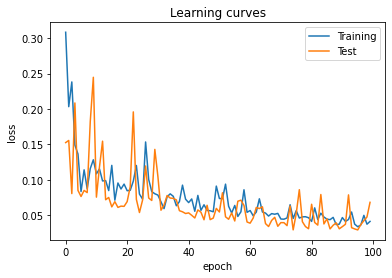

In [17]:
plt.plot(model_history.history['loss'], label='Training')
plt.plot(model_history.history['val_loss'], label='Test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Learning curves')
plt.legend(loc='upper right')
plt.show()

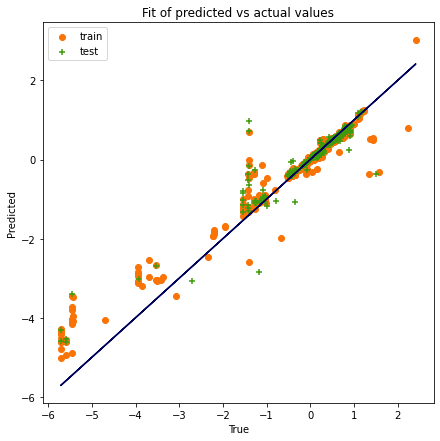

In [18]:
pred_test=Ann_model.predict(X_test)
pred_train=Ann_model.predict(X_train)

plt.figure(figsize=(7,7))
plt.scatter(y_train,pred_train, marker='o', color='#f97306', label='train' )
plt.scatter(y_test,pred_test, marker='+', color='#3f9b0b', label='test' )
plt.legend(loc='upper left')
plt.plot(y_train,y_train, color='#00035b')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Fit of predicted vs actual values')
plt.show()

In [19]:
from sklearn import metrics 
from sklearn.metrics import r2_score

In [20]:
print('MAE:', metrics.mean_absolute_error(y_test, pred_test))
print('MSE:', metrics.mean_squared_error(y_test, pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_test)))
print('R_squared:'+ str(round(r2_score(y_test,pred_test),2)))

MAE: 0.10326725682673871
MSE: 0.08146706201109861
RMSE: 0.28542435427114243
R_squared:0.89


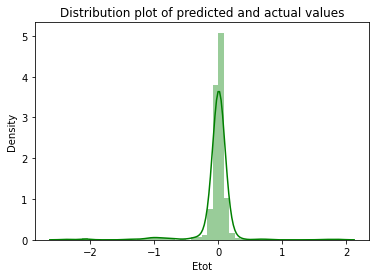

In [21]:
import seaborn as sns
sns.distplot(y_test-pred_test,color='Green')
plt.title('Distribution plot of predicted and actual values')
plt.xlabel('Etot');

In [22]:
y_test=scaler_y.inverse_transform(y_test)
np.mean(y_test)

-378.0379565217392

In [23]:
pred_test=scaler_y.inverse_transform(pred_test)
np.mean(pred_test)

-377.76602